In [ ]:
!unzip -qq skku-2024-1-machine-learning-third-project.zip -d ./data

replace ./data/SceneImages/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
Dataset = pd.read_csv('./data/train.csv')
Dataset.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,7.jpg,4
4,8.jpg,1


In [ ]:
Dataset["label"] = Dataset["label"].astype(str)

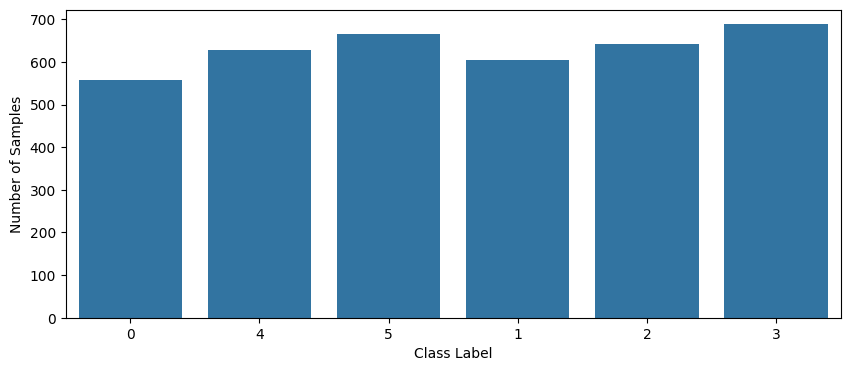

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.countplot(x ='label', data=Dataset)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
Data_train, Data_test = train_test_split(Dataset, test_size=0.2)
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
dir1 = './data/SceneImages/'

In [ ]:
train_gen=datagen.flow_from_dataframe(dataframe = Data_train,           # Training Dataframe
                                      directory=dir1,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_name",               # Input Column
                                      color_mode="rgb",                 # Image Format
                                      y_col="label",                    # Target Column
                                      target_size=(150,150))            # Image Size

Found 3028 validated image filenames belonging to 6 classes.


In [ ]:
valid_gen=datagen.flow_from_dataframe(dataframe = Data_test,            # Training Dataframe
                                      directory=dir1,                   # Training set Directory
                                      batch_size=20,                    # Size of Batch
                                      class_mode="categorical",         # Type of Labels
                                      x_col="image_name",               # Input Column
                                      color_mode="rgb",                 # Image Format
                                      y_col="label",                    # Target Column
                                      target_size=(150,150))

Found 757 validated image filenames belonging to 6 classes.


# ResNet

In [ ]:
import keras
ResNet_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(150,150, 3))

234545216/234545216 [==============================] - 12s 0us/step


In [ ]:
from keras import Model
from keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from keras.models import Sequential

In [ ]:
for layer in ResNet_model.layers[:-15]:       # Freezing all layers other than last 15 Layers
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=6, activation='softmax')(x)
model = Model(ResNet_model.input, output)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 77, 77, 64)           0         ['conv1_conv[0][0]']          
                                                                                              

In [ ]:
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

151
37


In [ ]:
import tensorflow as tf

# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # 모니터링할 값
    patience=3,              # 개선되지 않는 epoch 수 (여기서는 3으로 설정)
    restore_best_weights=True # 최적의 가중치를 복원
)

# 모델 학습
transfer_learning_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=10,  # 학습 epoch 수를 10으로 늘림
    callbacks=[early_stopping]  # 콜백 추가
)


Epoch 1/10


<ipython-input-18-87e84e74dace>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(


151/151 [==============================] - 23s 151ms/step - loss: 0.4111 - accuracy: 0.8773 - val_loss: 1.4357 - val_accuracy: 0.7946
Epoch 2/10
151/151 [==============================] - 21s 138ms/step - loss: 0.2779 - accuracy: 0.9159 - val_loss: 0.6935 - val_accuracy: 0.8635
Epoch 3/10
151/151 [==============================] - 19s 127ms/step - loss: 0.2218 - accuracy: 0.9362 - val_loss: 0.4416 - val_accuracy: 0.8716
Epoch 4/10
151/151 [==============================] - 20s 136ms/step - loss: 0.1801 - accuracy: 0.9478 - val_loss: 2.6025 - val_accuracy: 0.7635
Epoch 5/10
151/151 [==============================] - 21s 140ms/step - loss: 0.1180 - accuracy: 0.9641 - val_loss: 0.6465 - val_accuracy: 0.8865
Epoch 6/10
151/151 [==============================] - 21s 137ms/step - loss: 0.1037 - accuracy: 0.9694 - val_loss: 0.5251 - val_accuracy: 0.8730
Epoch 7/10
151/151 [==============================] - 21s 138ms/step - loss: 0.0840 - accuracy: 0.9744 - val_loss: 0.6381 - val_accuracy: 0.8

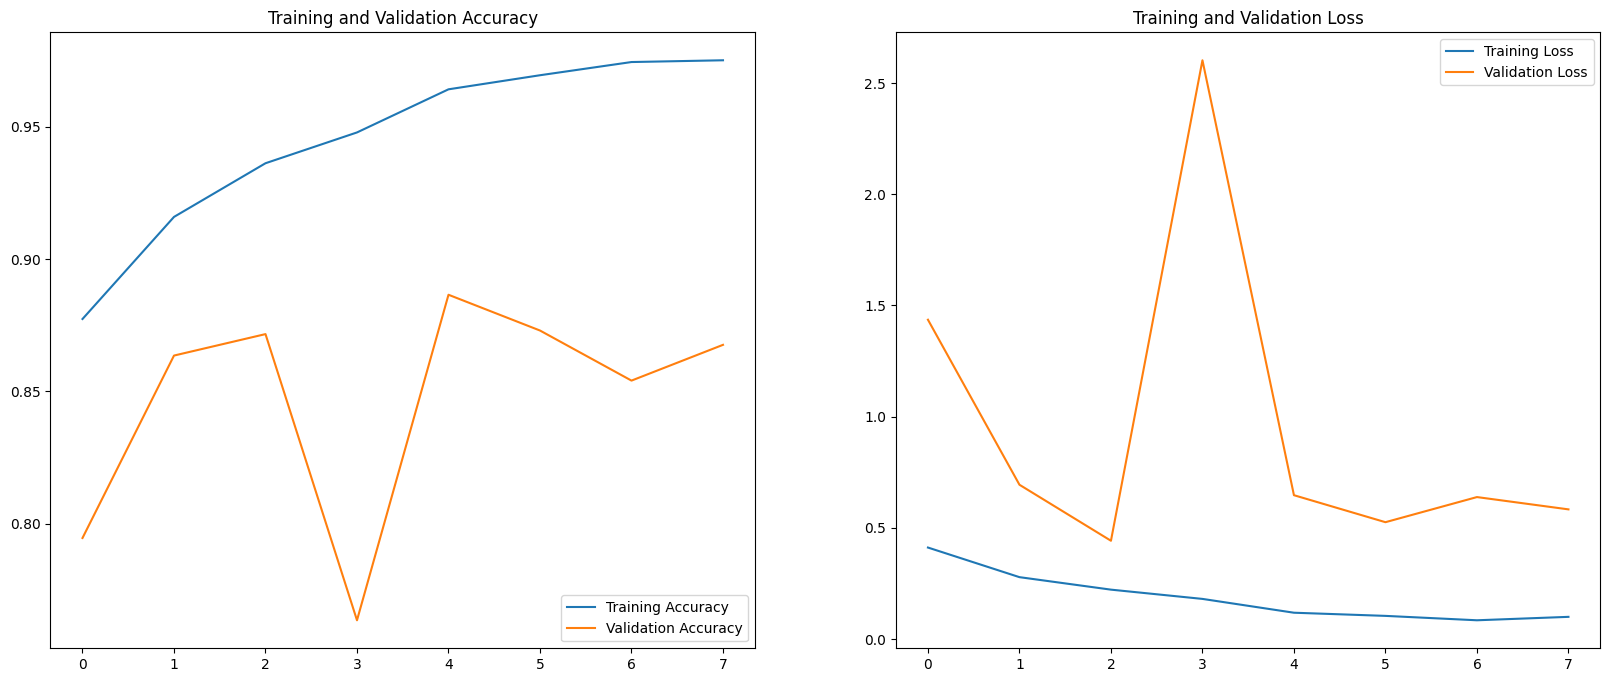

In [ ]:
import matplotlib.pyplot as plt

acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# test.csv 파일 읽기
test_dataset = pd.read_csv('./data/test.csv')
#test_dataset["label"] = test_dataset["label"].astype(str)

# ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 생성기 만들기
test_gen = test_datagen.flow_from_dataframe(dataframe=test_dataset,
                                            directory=dir1,
                                            x_col="image_name",
                                            color_mode="rgb",
                                            y_col=None,
                                            batch_size=20,
                                            class_mode="categorical",
                                            target_size=(150, 150),
                                            shuffle=False)

# 모델을 사용하여 예측 수행
predictions = model.predict_generator(test_gen, steps=test_gen.n // test_gen.batch_size + 1)
predicted_labels = predictions.argmax(axis=1)

# 예측 결과를 dataframe으로 변환
submission_df = pd.DataFrame({'image_name': test_dataset['image_name'], 'label': predicted_labels})

# submission.csv 파일로 저장
submission_df.to_csv('submission.csv', index=False)

print("Submission file has been created successfully!")


Found 440 validated image filenames.


<ipython-input-28-be08e948846e>:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=test_gen.n // test_gen.batch_size + 1)


Submission file has been created successfully!


# ConvNeXtXLarge

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=valid_gen.n//valid_gen.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

151
37


In [ ]:
model_name='ConvNeXtXLarge'
basemodel = tf.keras.applications.DenseNet121(weights = "imagenet",
                                              input_shape = (150,150, 3),include_top=False,pooling='max')
x= basemodel.output
x= keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output = Dense(6, activation="softmax")(x)

model = tf.keras.Model(inputs = basemodel.inputs, outputs = output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']      

In [ ]:
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # 모니터링할 값
    patience=5,              # 개선되지 않는 epoch 수 (여기서는 3으로 설정)
    restore_best_weights=True # 최적의 가중치를 복원
)

# 모델 학습
transfer_learning_history = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_gen,
    validation_steps=STEP_SIZE_VALID,
    epochs=20,  # 학습 epoch 수를 10으로 늘림
    callbacks=[early_stopping]  # 콜백 추가
)

Epoch 1/20


<ipython-input-14-0fbe934ebabb>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(


151/151 [==============================] - 95s 196ms/step - loss: 5.6073 - accuracy: 0.7826 - val_loss: 5.0474 - val_accuracy: 0.7365
Epoch 2/20
151/151 [==============================] - 22s 146ms/step - loss: 3.5219 - accuracy: 0.8891 - val_loss: 3.1414 - val_accuracy: 0.8973
Epoch 3/20
151/151 [==============================] - 21s 141ms/step - loss: 2.5005 - accuracy: 0.9342 - val_loss: 2.2872 - val_accuracy: 0.8986
Epoch 4/20
151/151 [==============================] - 21s 139ms/step - loss: 1.8357 - accuracy: 0.9644 - val_loss: 1.7665 - val_accuracy: 0.8905
Epoch 5/20
151/151 [==============================] - 22s 146ms/step - loss: 1.3741 - accuracy: 0.9757 - val_loss: 1.4035 - val_accuracy: 0.8905
Epoch 6/20
151/151 [==============================] - 21s 136ms/step - loss: 1.0306 - accuracy: 0.9837 - val_loss: 1.1312 - val_accuracy: 0.9027
Epoch 7/20
151/151 [==============================] - 22s 147ms/step - loss: 0.8122 - accuracy: 0.9781 - val_loss: 1.1199 - val_accuracy: 0.8

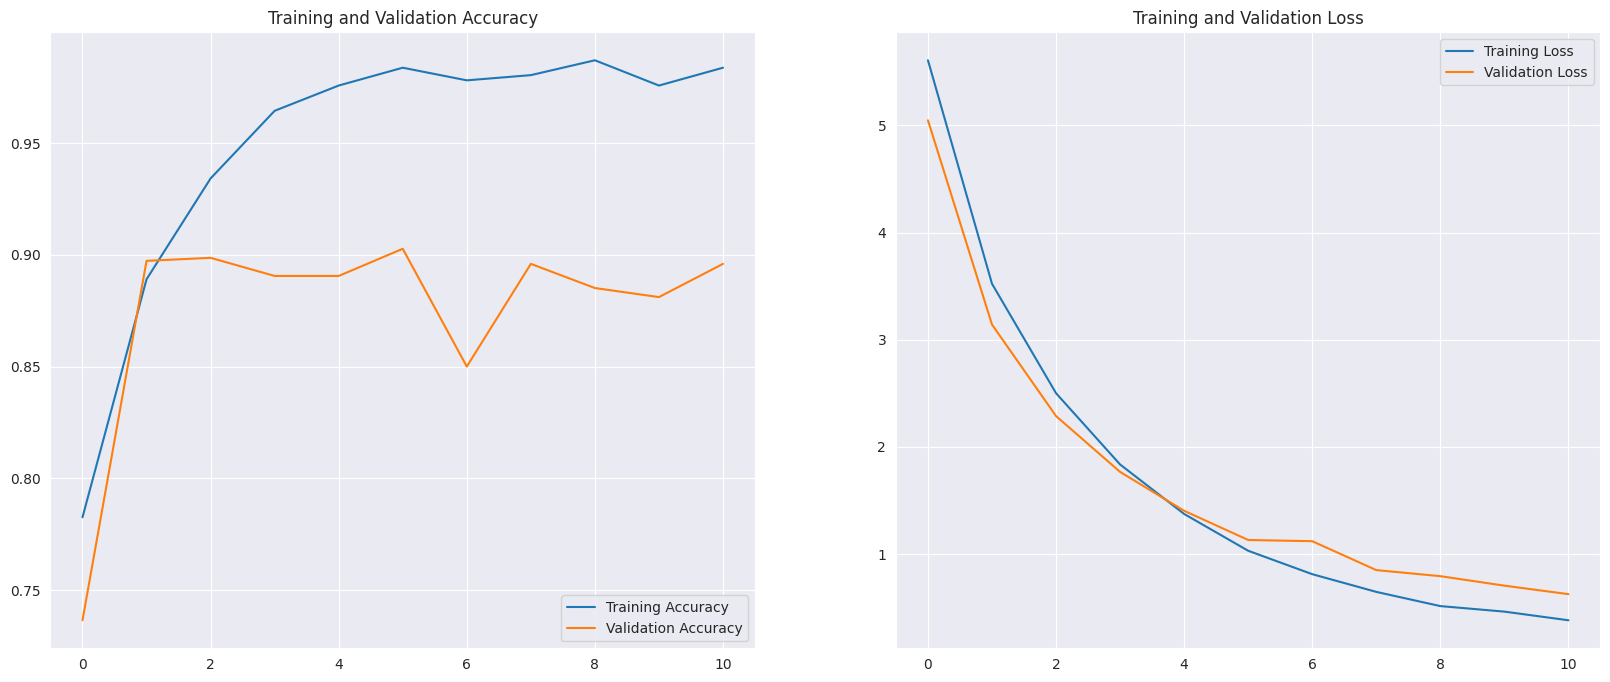

In [ ]:
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']

loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# test.csv 파일 읽기
test_dataset = pd.read_csv('./data/test.csv')

# ImageDataGenerator 생성
test_datagen = ImageDataGenerator(rescale=1./255)

# 테스트 데이터 생성기 만들기
test_gen = test_datagen.flow_from_dataframe(dataframe=test_dataset,
                                            directory=dir1,
                                            x_col="image_name",
                                            color_mode="rgb",
                                            y_col=None,
                                            batch_size=20,
                                            class_mode=None,
                                            target_size=(150, 150),
                                            shuffle=False)

# 모델을 사용하여 예측 수행
predictions = model.predict_generator(test_gen, steps=test_gen.n // test_gen.batch_size + 1)
predicted_labels = predictions.argmax(axis=1)

# 예측 결과를 dataframe으로 변환
submission_df = pd.DataFrame({'image_name': test_dataset['image_name'], 'label': predicted_labels})

# submission.csv 파일로 저장
submission_df.to_csv('submission.csv', index=False)

Found 440 validated image filenames.


<ipython-input-18-6f6534bd20b3>:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=test_gen.n // test_gen.batch_size + 1)
